In [8]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.linear_model import LinearRegression

Infant mortality rate (per 1000 live births                  -0.702155
Pop. using improved sanitation facilities (urban/rural, %)   -0.701874
Fertility rate, total (live births per woman)                -0.635398
Economy: Agriculture (% of GVA)                              -0.596738
Employment: Agriculture (% of employed)                      -0.579133
Name: Happiness, dtype: float64
Economy: Services and other activity (% of GVA)          0.580328
Urban population (% of total population)                 0.666212
Employment: Services (% of employed)                     0.709983
GDP per capita (current US$)                             0.729044
Mobile-cellular subscriptions (per 100 inhabitants).1    0.789833
Name: Happiness, dtype: float64


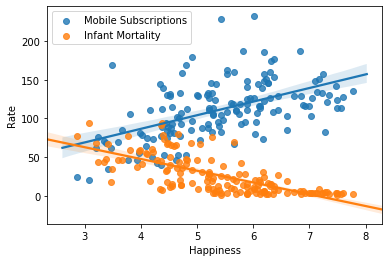

In [191]:
happiness = pd.read_csv('2019d.csv')
stats_toomany = pd.read_csv('country_statsd.csv')

keep_countries = [] #list of common countries
for i in stats_toomany.country:
    for j in happiness['Country or region']: #search thru the happiness file
        if i==j:                             #and see if the country names match
            keep = keep_countries.append(i)  #if they do, add them to the common list

#creating new dataframe with all columns of stats_toomany, 
#but only for countries that are also in the happiness dataset

stats = stats_toomany[(stats_toomany['country'].isin(keep_countries))]

# checking that datasets match
stats.sort_values(by=['country'])
happiness.sort_values(by=['Country or region'])
stats.shape
happiness.shape
stats.head(5)

#Using the clean data to find correlations
#on a scale of -1 to 1

# adding the happiness scores to the stats dataset to check correlations
stats.sort_values(by=['country'])
happiness.sort_values(by=['Country or region'])
stats['Happiness']=happiness['Score']
stats = stats.set_index('country')

stats.replace(to_replace='...', value =0, inplace=True) #changing strings to integers
stats.replace(to_replace='~0.0', value =0, inplace=True)
stats.replace(to_replace='-~0.0', value =0, inplace=True)
list_of_columns_ToBeFloats = stats.columns[3:]
for col in list_of_columns_ToBeFloats:
    stats[col] = stats[col].astype(float)
    
# checking correlations between all numeric attributes
correlations = stats.corr()
correlations.sort_values(by=['Happiness'], inplace=True)
correlations
bottom5cor = correlations[:5]['Happiness']
print(bottom5cor)
top5cor = correlations[-6:-1]['Happiness']
print(top5cor)

#since mobile cell subscriptions seems to have the biggest positive
#effect on happiness let's plot it

a=sns.regplot(x=stats['Happiness'], y=stats['Mobile-cellular subscriptions (per 100 inhabitants)'],label="Mobile Subscriptions");

#since Infant mortality rate seems to have the 
#biggest negative effect on happiness let's plot it
a=sns.regplot(x=stats['Happiness'], y=stats['Infant mortality rate (per 1000 live births'], label="Infant Mortality");
a.set(ylabel="Rate")
a.legend()

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [531]:
# Creating a Multiple Linear Regression model to predict happiness score
X = stats.iloc[:, 1:-1]
Y = stats.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state= 111)

happiness_model = linear_model.LinearRegression()
happiness_model.fit(X_train, Y_train)

# coeff_corrs = pd.DataFrame(happiness_model.coef_, X.columns, columns=['Coefficient'])
# print(coeff_corrs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

                          Real Value  Prediction Value
country                                               
Hong Kong                      5.430          6.299637
South Africa                   4.722          5.477215
Comoros                        3.973          3.831765
Latvia                         5.940          6.284237
Central African Republic       3.083          4.450132


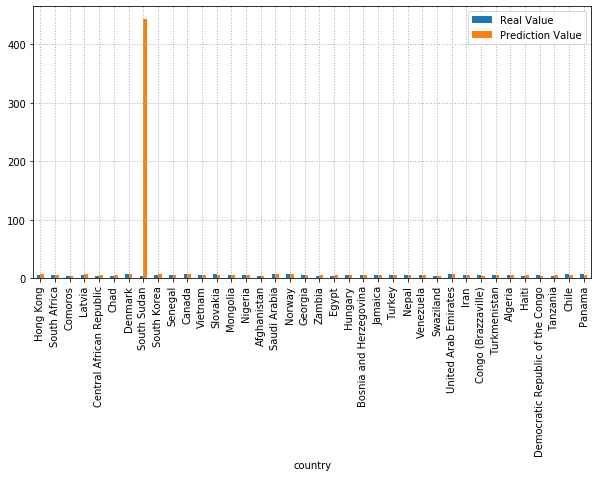

In [539]:
# predicting happiness score, and plotting against the real values
y_pred = happiness_model.predict(X_test)

checking_pred = pd.DataFrame({'Real Value': Y_test, 'Prediction Value': y_pred})
print(checking_pred.head())

checking_pred.plot(kind='bar', figsize=(10,5))
plt.grid(which='major', linestyle=':', linewidth='1')
plt.show()

In [368]:
# checking the measures of how fit the model is
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))      
r2_value = r2_score(Y_test, y_pred)                     

print("Intercept: \n", happiness_model.intercept_)
print("Root Mean Square Error \n", rmse)
print("R^2 Value: \n", r2_value)

Intercept: 
 110.67266386289029
Root Mean Square Error 
 71.38837700762701
R^2 Value: 
 -3617.9907298736966


In [540]:
# Shockingly (not),the predictions were very bad...
# Now let's try to make a model where the independent attributes are the top/bottom 5 correlations (from first code block).
X2 = stats.iloc[:, [26, -2, 24, 8, 11, 10, 22, 13, 7, 32]]
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, random_state= 111)

happiness_model2 = linear_model.LinearRegression()
happiness_model2.fit(X2_train, Y2_train)

# checking the coefficients
coeff_corrs2 = pd.DataFrame(happiness_model2.coef_, X2.columns, columns=['Coefficient'])
print(coeff_corrs2)

                                                    Coefficient
Infant mortality rate (per 1000 live births            0.000676
Pop. using improved sanitation facilities (urba...    -0.002094
Fertility rate, total (live births per woman)         -0.094369
Economy: Agriculture (% of GVA)                        0.000858
Employment: Agriculture (% of employed)                0.006378
Economy: Services and other activity (% of GVA)       -0.000081
Urban population (% of total population)               0.003080
Employment: Services (% of employed)                   0.018159
GDP per capita (current US$)                           0.000015
Mobile-cellular subscriptions (per 100 inhabita...     0.009003


                          Actual  Predicted
country                                    
Hong Kong                  5.430   7.025409
South Africa               4.722   5.470586
Comoros                    3.973   4.439881
Latvia                     5.940   6.182011
Central African Republic   3.083   4.268366
Chad                       4.350   4.127884
Denmark                    7.600   7.106790
South Sudan                2.853   0.997072
South Korea                5.895   6.557163
Senegal                    4.681   4.403062


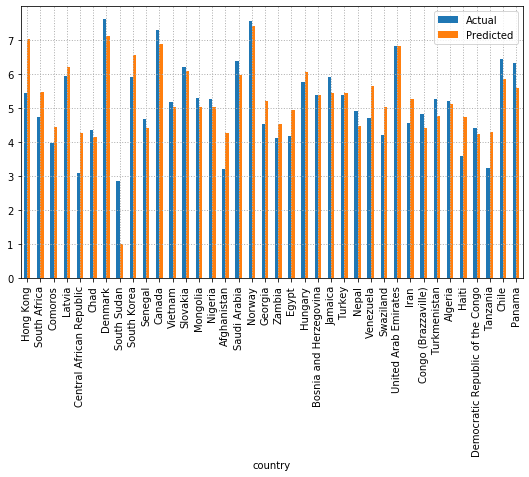

Intercept: 
 3.6721624428151136
Root Mean Square Error 
 0.6925705828399503
R^2 Value: 
 0.6593875366207194


In [541]:
# plotting the prediction against the real values, and checking the measures of how fit the model is
y2_pred = happiness_model2.predict(X2_test)

checking_pred2 = pd.DataFrame({'Actual': Y2_test, 'Predicted': y2_pred})
print(checking_pred2.head(10))

checking_pred2.plot(kind='bar', figsize=(9,5))
plt.grid(which='major', linestyle=':', linewidth='1')
plt.show()

rmse2 = np.sqrt(mean_squared_error(Y2_test, y2_pred))      
r2_value2 = r2_score(Y2_test, y2_pred)                     

print("Intercept: \n", happiness_model2.intercept_)
print("Root Mean Square Error \n", rmse2)
print("R^2 Value: \n", r2_value2)

In [372]:
# checking the Variance Inflation Factors 
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif2["features"] = X2.columns
vif2

,VIF Factor,features
0,16.225653,Infant mortality rate (per 1000 live births
1,4.418741,Pop. using improved sanitation facilities (urb...
2,25.805331,"Fertility rate, total (live births per woman)"
3,6.306982,Economy: Agriculture (% of GVA)
4,6.298871,Employment: Agriculture (% of employed)
5,29.702015,Economy: Services and other activity (% of GVA)
6,22.389364,Urban population (% of total population)
7,22.140977,Employment: Services (% of employed)
8,4.673560,GDP per capita (current US$)
9,23.504916,Mobile-cellular subscriptions (per 100 inhabit...


In [548]:
# Looking for the optimal linear regression model via trial and error.
# Trying different combinations of independent variables used in the model and comparing their
# measures, while changing the testing vs. training splits (test_size) in order to get the optimal model.

X3 = stats.iloc[:, [26, -2, 11, 13, 7, 3, 6, 25, 27, 28, 32, 33, 35]] 
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y,  test_size=0.20, random_state= 111)

happiness_model3 = linear_model.LinearRegression()
happiness_model3.fit(X3_train, Y3_train)

coeff_corrs3 = pd.DataFrame(happiness_model3.coef_.round(decimals=6, out=None), X3.columns, columns=['Coefficient'])
print(coeff_corrs3)


                                                    Coefficient
Infant mortality rate (per 1000 live births            0.003275
Pop. using improved sanitation facilities (urba...    -0.001334
Employment: Agriculture (% of employed)               -0.006875
Employment: Services (% of employed)                   0.012773
GDP per capita (current US$)                           0.000014
Population density (per km2, 2017)                    -0.000107
GDP growth rate (annual %, const. 2005 prices)         0.022882
Refugees and others of concern to UNHCR (in tho...    -0.000090
Health: Total expenditure (% of GDP)                   0.000295
Health: Physicians (per 1000 pop.)                     0.008601
Mobile-cellular subscriptions (per 100 inhabita...     0.011627
Individuals using the Internet (per 100 inhabit...     0.000224
CO2 emission estimates (million tons/tons per c...    -0.000004


                          Actual  Predicted
country                                    
Hong Kong                  5.430   5.281978
South Africa               4.722   5.685062
Comoros                    3.973   4.394585
Latvia                     5.940   6.211300
Central African Republic   3.083   4.235535
Chad                       4.350   4.222760
Denmark                    7.600   7.096057
South Sudan                2.853   2.897631
South Korea                5.895   6.512176
Senegal                    4.681   4.600618


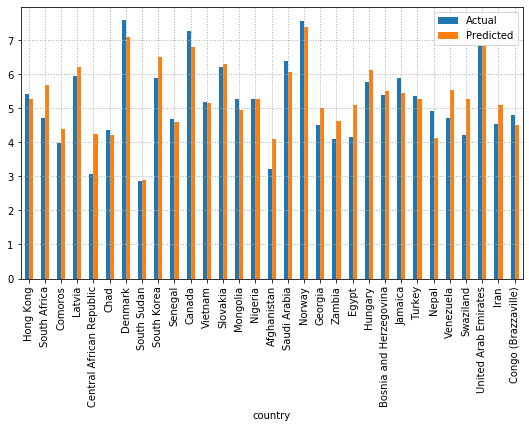

Intercept: 
 4.030352290870416
Root Mean Square Error 
 0.5403140896052697
R^2 Value: 
 0.7936224568401856


In [549]:
y3_pred = happiness_model3.predict(X3_test)

checking_pred3 = pd.DataFrame({'Actual': Y3_test, 'Predicted': y3_pred})
print(checking_pred3.head(10))


checking_pred3.plot(kind='bar', figsize=(9,5))
plt.grid(which='major', linestyle=':', linewidth='1')
plt.show()

rmse3 = np.sqrt(mean_squared_error(Y3_test, y3_pred))      
r2_value3 = r2_score(Y3_test, y3_pred)                     

print("Intercept: \n", happiness_model3.intercept_)
print("Root Mean Square Error \n", rmse3)
print("R^2 Value: \n", r2_value3)

In [550]:
vif3 = pd.DataFrame()
vif3["VIF Factor"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif3["features"] = X3.columns
print(vif3)

# we see that ""% of employed in services" and "mobile subscriptions %" have multicollinearity, but taking each of them 
# out reduces r-squared and increases rmse, so i'm leaving it in

    VIF Factor                                           features
0     5.123977        Infant mortality rate (per 1000 live births
1     4.533146  Pop. using improved sanitation facilities (urb...
2     5.120320            Employment: Agriculture (% of employed)
3    13.411638               Employment: Services (% of employed)
4     4.594473                       GDP per capita (current US$)
5     1.446299                 Population density (per km2, 2017)
6     1.397682     GDP growth rate (annual %, const. 2005 prices)
7     1.299202  Refugees and others of concern to UNHCR (in th...
8     1.544092               Health: Total expenditure (% of GDP)
9     1.885931                 Health: Physicians (per 1000 pop.)
10   15.658167  Mobile-cellular subscriptions (per 100 inhabit...
11    1.912535  Individuals using the Internet (per 100 inhabi...
12    1.362695  CO2 emission estimates (million tons/tons per ...
